In [1]:
pip install tensorflow_model_optimization

     |████████████████████████████████| 237 kB 4.4 MB/s 


In [2]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import math

In [3]:
#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

In [4]:
#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
#import pruning stuff
import tensorflow_model_optimization as tfmot

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.8.0


In [6]:
#  define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                             patience = 15, 
                                             restore_best_weights = True)

In [7]:
#build data generators for training and validaton

split = 0.2

total_train = 3200
total_val = 800


# Define dirs and files
train_data_dir = '/content/drive/MyDrive/Project'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 45,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 150

#set Image size (RGB so imshape is 3)
pix_dim = 320
imsize = (pix_dim,240) 
imshape = (pix_dim,240,1)


# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    color_mode = 'grayscale',
                                                    target_size = imsize,
                                                    subset='training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        color_mode = 'grayscale',
                                                        target_size = imsize,
                                                        subset='validation')

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [8]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=imshape),
    layers.Conv2D(filters=32, kernel_size=3, strides = 2, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Conv2D(64, 3, strides = 2, padding='same', activation='relu'),
    layers.MaxPool2D(),

    layers.Conv2D(64, 3, strides = 2, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8,activation = "softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 120, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 30, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 8, 64)         36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 4, 64)         0

In [9]:
#build the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = 'accuracy')

In [11]:
#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 50,
                    validation_steps =  total_val // batch_size,
                    callbacks =[callbacks])

Epoch 1/50
21/21 [==============================] - 536s 26s/step - loss: 2.0813 - accuracy: 0.1266 - val_loss: 2.0771 - val_accuracy: 0.2093
Epoch 2/50
21/21 [==============================] - 67s 3s/step - loss: 2.0699 - accuracy: 0.1384 - val_loss: 2.0503 - val_accuracy: 0.1307
Epoch 3/50
21/21 [==============================] - 66s 3s/step - loss: 2.0008 - accuracy: 0.1879 - val_loss: 1.8596 - val_accuracy: 0.2600
Epoch 4/50
21/21 [==============================] - 66s 3s/step - loss: 1.8570 - accuracy: 0.2384 - val_loss: 1.8336 - val_accuracy: 0.2667
Epoch 5/50
21/21 [==============================] - 67s 3s/step - loss: 1.7720 - accuracy: 0.2652 - val_loss: 1.7662 - val_accuracy: 0.2800
Epoch 6/50
21/21 [==============================] - 67s 3s/step - loss: 1.7332 - accuracy: 0.2767 - val_loss: 1.6881 - val_accuracy: 0.3280
Epoch 7/50
21/21 [==============================] - 67s 3s/step - loss: 1.7067 - accuracy: 0.2754 - val_loss: 1.6626 - val_accuracy: 0.2987
Epoch 8/50
21/21 [

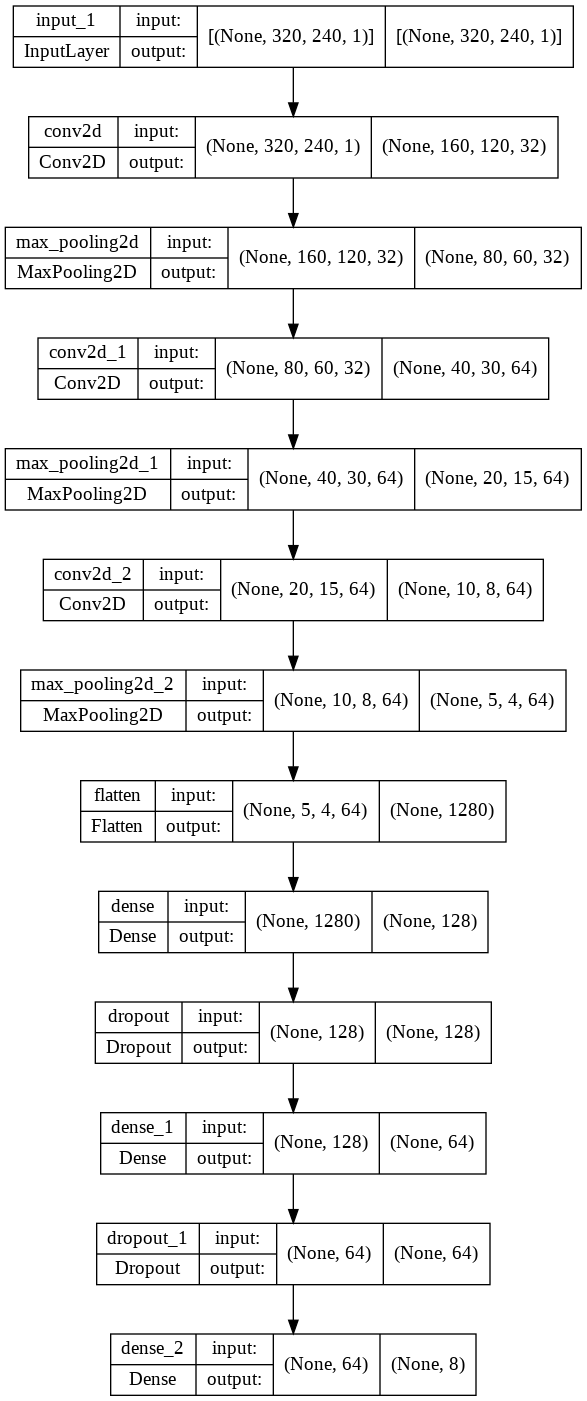

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

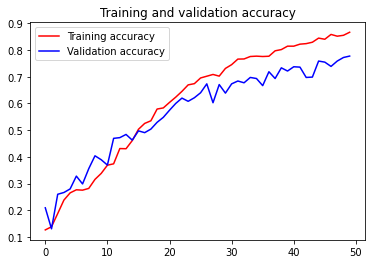

<Figure size 432x288 with 0 Axes>

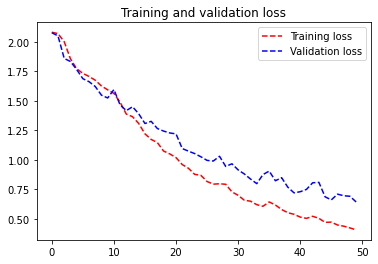

<Figure size 432x288 with 0 Axes>

In [12]:
#look at the metrics from training
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [13]:
#save the model
filepath = '/content/drive/MyDrive/Deployment/roadsignNet_reg'
model.save(filepath)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deployment/MokaPotNet_reg/assets


In [19]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude


epochs = 10


end_step = np.ceil(1.0 * total_train / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.8,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = 'accuracy')

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 160, 120, 32)     610       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_max_poo  (None, 80, 60, 32)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 40, 30, 64)       36930     


/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 20, 15, 64)       1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_conv2d_  (None, 10, 8, 64)        73794     
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 5, 4, 64)         1         
 ling2d_2 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_flatten  (None, 1280)             1         
  (PruneLowMagnitude)                                            
          

In [20]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

phistory = model_for_pruning.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 4,
                    validation_steps =  total_val // batch_size,
                    callbacks =callbacks)

Epoch 1/4
21/21 [==============================] - 75s 3s/step - loss: 0.8218 - accuracy: 0.6984 - val_loss: 0.8109 - val_accuracy: 0.7213
Epoch 2/4
21/21 [==============================] - 68s 3s/step - loss: 0.6322 - accuracy: 0.7820 - val_loss: 0.7888 - val_accuracy: 0.7187
Epoch 3/4
21/21 [==============================] - 67s 3s/step - loss: 0.5106 - accuracy: 0.8302 - val_loss: 0.7559 - val_accuracy: 0.7200
Epoch 4/4
21/21 [==============================] - 67s 3s/step - loss: 0.4664 - accuracy: 0.8430 - val_loss: 0.6802 - val_accuracy: 0.7520


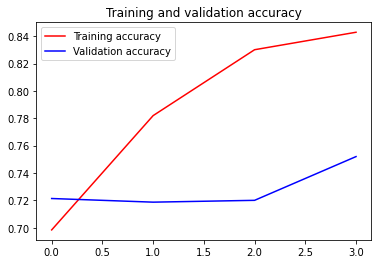

<Figure size 432x288 with 0 Axes>

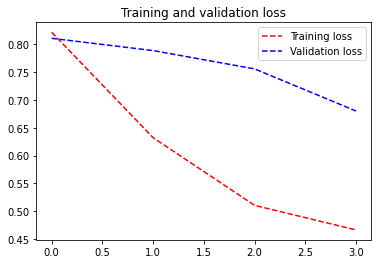

<Figure size 432x288 with 0 Axes>

In [23]:
#look at the metrics from training
%matplotlib inline

acc = phistory.history['accuracy']
val_acc = phistory.history['val_accuracy']
loss = phistory.history['loss']
val_loss = phistory.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [28]:
# get the pruned model ready
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)



# #quantize

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:

num_calibration_steps = 1
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        # Get sample input data as a numpy array in a method of your choosing.
        ## Ideally we should do a validation calibration but we are using all of the training data for max acc
#         x =np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
        x =np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
        print(x.shape)
        yield [x]
converter.representative_dataset = representative_dataset_gen

tflite_model = converter.convert()

with open('/content/drive/MyDrive/Deployment/roadsignNet_QuantPruned1.tflite','wb') as f:
    f.write(tflite_model)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

INFO:tensorflow:Assets written to: /tmp/tmpmq5xbrwm/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
